# Nipype Workshop
 
 8-22-2017

# What you need

* A laptop
* With Docker installed
* You've run `docker pull nipype/nipype:latest`
* Downloaded [data](https://openfmri.org/dataset/ds000102/)

# Docker

presentation: http://nipy.org/workshops/2017-03-boston/lectures/lesson-container/#1

#### file structure:

/path/to/nipype_workshop:

```
|___ data/
       |___ds102_R2.0.0/
           |___ sub-01
|___ Dockerfile
|___ start_notebook.sh
   
```

data can be downloaded [here](https://s3.amazonaws.com/openneuro/ds000102/ds000102_R2.0.0/compressed/ds102_R2.0.0_all_data.tgz)

you can get an MNI template [here](https://osf.io/kmfau/download)

#### Dockerfile

```
    FROM nipype/nipype:latest
    RUN conda install jupyter
    EXPOSE 8888
    RUN git clone https://github.com/akeshavan/nbpapaya && \
        cd nbpapaya && \
        git submodule update --init --recursive &&\
        python setup.py install
    RUN pip install pybids
    RUN chmod ugo+x /opt/spm12/run_spm12.sh /opt/spm12/spm12_glnxa64
    RUN chmod ugo+w /opt/spm12
    RUN chmod ugo+w /opt/spm12/spm12_glnxa64.ctf
    ENV NB_USER anisha #add your name here
    RUN useradd -m -s /bin/bash -N -u 1000 $NB_USER
    USER $NB_USER
    COPY start_notebook.sh /work/start_notebook.sh
    ENTRYPOINT ["/work/start_notebook.sh"]
```

#### start_notebook.sh

```bash

#!/bin/bash
cd /data
jupyter notebook --ip=0.0.0.0 --no-browser

```

change the permissions of start_notebook.sh so it is executeable:

```bash
chmod u+x start_notebook.sh
```

** Build the docker container:**

```bash
docker build -ti my_env .
```

** Run the docker container:**

```
docker run -ti -v $PWD:/data -p 8888:8888 --rm myenv

```

** See all running containers:**

```
docker ps
```

you should see a chart with CONTAINER_ID as the first column.


** Open a new terminal in a running container:**

```
docker exec -ti <container_id> /bin/bash
```

### View a nifti volume:

In [1]:
from nbpapaya import Brain
Brain(["/data/data/ds102_R2.0.0/sub-01/anat/sub-01_T1w.nii.gz"])

doing checks /home/anisha/.jupyter/custom/


In [2]:
from nilearn.plotting import plot_anat, plot_epi, plot_roi, plot_stat_map
%matplotlib inline

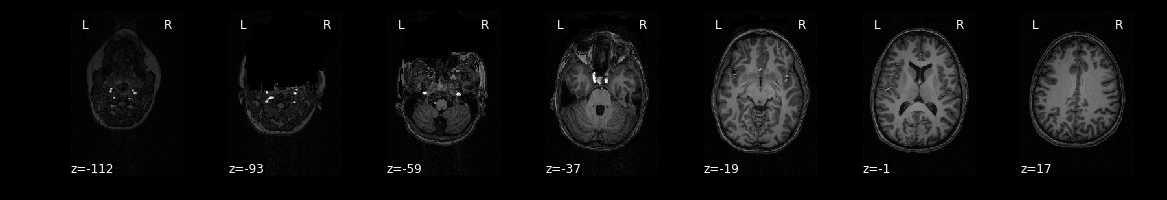

In [19]:
plot_anat("/data/data/ds102_R2.0.0/sub-01/anat/sub-01_T1w.nii.gz", display_mode="z", dim=-1)

# Nipype

Reference notebooks, based on Michael Notter's tutorials: https://djarecka.github.io/nipype_tutorial/

1. **Intro to Nipype** https://djarecka.github.io/nipype_tutorial/notebooks/introduction_nipype.slides.html?#/
2. **Nipype** interfaces: https://djarecka.github.io/nipype_tutorial/notebooks/basic_interfaces.html
3. **Nipype documentation**: http://nipype.readthedocs.io/en/latest/documentation.html

## Interfaces

### Skull strip w/ FSL's BET

In [5]:
import nipype.interfaces.fsl as fsl

In [7]:
bet = fsl.BET()
bet.help()

Wraps command **bet**

Use FSL BET command for skull stripping.

For complete details, see the `BET Documentation.
<https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET/UserGuide>`_

Examples
--------
>>> from nipype.interfaces import fsl
>>> btr = fsl.BET()
>>> btr.inputs.in_file = 'structural.nii'
>>> btr.inputs.frac = 0.7
>>> btr.inputs.out_file = 'brain_anat.nii'
>>> btr.cmdline  # doctest: +ALLOW_UNICODE
'bet structural.nii brain_anat.nii -f 0.70'
>>> res = btr.run() # doctest: +SKIP

Inputs::

	[Mandatory]
	in_file: (an existing file name)
		input file to skull strip
		flag: %s, position: 0

	[Optional]
	args: (a unicode string)
		Additional parameters to the command
		flag: %s
	center: (a list of at most 3 items which are an integer (int or
		 long))
		center of gravity in voxels
		flag: -c %s
	environ: (a dictionary with keys which are a bytes or None or a value
		 of class 'str' and with values which are a bytes or None or a value
		 of class 'str', nipype default value: {})
		Environme

In [10]:
bet.inputs.in_file = "/data/data/ds102_R2.0.0/sub-01/anat/sub-01_T1w.nii.gz"
bet.inputs.out_file = "sub01_T1w_bet.nii.gz"
bet.cmdline

'bet /data/data/ds102_R2.0.0/sub-01/anat/sub-01_T1w.nii.gz sub01_T1w_bet.nii.gz'

In [ ]:
res = bet.run()

In [12]:
Brain(["/data/data/ds102_R2.0.0/sub-01/anat/sub-01_T1w.nii.gz",
       res.outputs.out_file])

doing checks /home/anisha/.jupyter/custom/


* set both colormap layers from 0 to 1000

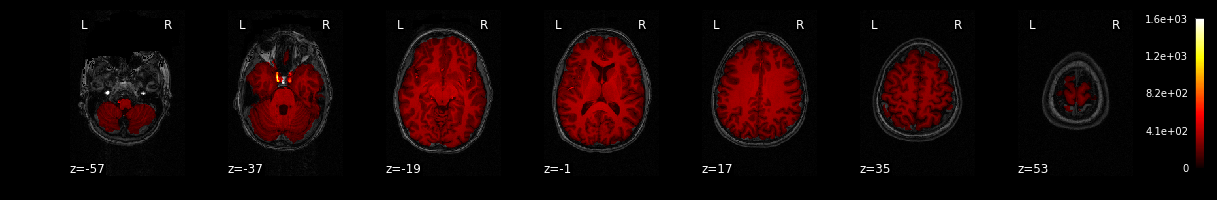

In [20]:
plot_stat_map(res.outputs.out_file,
              "/data/data/ds102_R2.0.0/sub-01/anat/sub-01_T1w.nii.gz", 
              display_mode="z",
              dim=-1,
              threshold=0)

### Problems:

1. Rerun BET so that it also writes the binary mask file
2. Run fsl's MCFLIRT to realign the functional image for both functional runs of sub-01 
3. Plot the motion parameters of the outputs of MCFLIRT
4. Run fsl's FAST to segment the anatomical

## Nodes

Notebook: https://djarecka.github.io/nipype_tutorial/notebooks/basic_nodes.html

* Nodes can be **connected** 

* Types of nodes:
  * Node
  * MapNode
  * JoinNode

#### Example of a simple node

First, let us take a look at a simple stand-alone node. In general, a node consists of the following elements:

```python
nodename = Nodetype(interface_function(), name='labelname')
```

* **nodename**: Variable name of the node in the python environment.
* **Nodetype**: Type of node to be created. This can be a Node, MapNode or JoinNode.
* **interface_function**: Function the node should execute. Can be user specific or coming from an Interface.
* **labelname**: Label name of the node in the workflow environment (defines the name of the working directory)

In [23]:
# Import BET from the FSL interface
from nipype.interfaces.fsl import BET

# Import the Node module
from nipype import Node

# Create Node
bet = Node(BET(), name='bet_node')
bet.inputs.in_file = "/data/data/ds102_R2.0.0/sub-01/anat/sub-01_T1w.nii.gz"
bet.base_dir = "./working"
res = bet.run()
print(res.outputs.out_file)

170819-23:59:43,984 workflow INFO:
	 Executing node bet_node in dir: /data/working/bet_node
170819-23:59:44,9 workflow INFO:


Try running the above node again -- what's different?

#### The MapNode

In [26]:
from nipype import MapNode

# Create Node
bet = MapNode(BET(), name='bet_node', iterfield=["in_file"])
bet.inputs.in_file = ["/data/data/ds102_R2.0.0/sub-01/anat/sub-01_T1w.nii.gz", 
                      "/data/data/ds102_R2.0.0/sub-02/anat/sub-02_T1w.nii.gz"] #in file is a list 
bet.base_dir = "./working"
res = bet.run()
print(res.outputs.out_file)

170820-00:03:00,220 workflow INFO:
	 Executing node bet_node in dir: /data/working/bet_node
170820-00:03:00,331 workflow INFO:
	 Executing node _bet_node0 in dir: /data/working/bet_node/mapflow/_bet_node0
170820-00:03:00,440 workflow INFO:
	 Running: bet /data/data/ds102_R2.0.0/sub-01/anat/sub-01_T1w.nii.gz /data/working/bet_node/mapflow/_bet_node0/sub-01_T1w_brain.nii.gz
170820-00:03:07,255 workflow INFO:
	 Executing node _bet_node1 in dir: /data/working/bet_node/mapflow/_bet_node1
170820-00:03:07,332 workflow INFO:
	 Running: bet /data/data/ds102_R2.0.0/sub-02/anat/sub-02_T1w.nii.gz /data/working/bet_node/mapflow/_bet_node1/sub-02_T1w_brain.nii.gz
['/data/working/bet_node/mapflow/_bet_node0/sub-01_T1w_brain.nii.gz', '/data/working/bet_node/mapflow/_bet_node1/sub-02_T1w_brain.nii.gz']


#### The Function Interface in a Node

In [29]:
from nipype import Node, Function

# Create a small example function
def add_two(x_input):
    return x_input + 2

# Create Node
addtwo = Node(Function(input_names=["x_input"],
                       output_names=["val_output"],
                       function=add_two),
              name='add_node')

In [31]:
addtwo.inputs.x_input = 4
res = addtwo.run()

170820-00:06:49,232 workflow INFO:
	 Executing node add_node in dir: /tmp/tmpqn4dupg9/add_node
170820-00:06:49,239 workflow INFO:


In [32]:
res.outputs.val_output

6

* if you change the input_name to `y_output` does it still work?
* if you chage the output_name to `blah` does it still work?
* use a numpy function to sum over an array. Where do you put the import statement?

#### Problems

1. Run fsl's MCFLIRT to realign the functional image for both functional runs of sub-01 with a **MapNode**
2. Plot the motion parameters of the outputs of MCFLIRT using a **function interface and MapNode**

## Workflows

### Connecting Nodes


```python

from nipype import Workflow

wf = Workflow("workflow_name")

wf.connect(source_node, "source_output", dest_node, "dest_input")

wf.connect([(source_node, dest_node, [("source_output1", "dest_input1"),
                         ("source_output2", "dest_input2")
                         ])
         ])
 ```

In [35]:
from nipype import Workflow

In [40]:
from nipype.interfaces.fsl import FAST

wf = Workflow("preproc")
wf.base_dir = "./working/" ## Always define this!!

bet = Node(BET(), name='bet_node')
bet.inputs.in_file = "/data/data/ds102_R2.0.0/sub-01/anat/sub-01_T1w.nii.gz"

fast = Node(FAST(), name="fast")

wf.connect(bet, "out_file", fast, "in_files")

In [41]:
wf.write_graph()

170820-15:10:56,94 workflow INFO:
	 Generated workflow graph: ./working/preproc/graph.dot.png (graph2use=hierarchical, simple_form=True).


'./working/preproc/graph.dot.png'

In [42]:
from IPython.display import Image

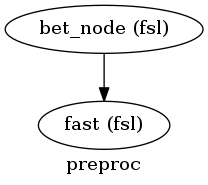

In [43]:
Image("./working/preproc/graph.dot.png")

In [44]:
wf.run()

170820-15:12:15,171 workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging']
170820-15:12:15,265 workflow INFO:
	 Running serially.
170820-15:12:15,269 workflow INFO:
	 Executing node bet_node in dir: /data/working/preproc/bet_node
170820-15:12:15,342 workflow INFO:
	 Running: bet /data/data/ds102_R2.0.0/sub-01/anat/sub-01_T1w.nii.gz /data/working/preproc/bet_node/sub-01_T1w_brain.nii.gz
170820-15:12:22,647 workflow INFO:
	 Executing node fast in dir: /data/working/preproc/fast
170820-15:12:22,723 workflow INFO:
	 Running: fast -S 1 /data/working/preproc/fast/sub-01_T1w_brain.nii.gz


Where are the results?

In [46]:
ls ./working/preproc/*

./working/preproc/d3.js          ./working/preproc/graph.json
./working/preproc/graph.dot      ./working/preproc/graph1.json
./working/preproc/graph.dot.png  ./working/preproc/index.html

./working/preproc/bet_node:
_0xfb03e77800240ceab457974f04333969.json  command.txt
_inputs.pklz                              result_bet_node.pklz
_node.pklz                                sub-01_T1w_brain.nii.gz
_report/

./working/preproc/fast:
_0x0dabe2ef8e5245a58fc428182ab7e5a0.json  sub-01_T1w_brain_mixeltype.nii.gz
_inputs.pklz                              sub-01_T1w_brain_pve_0.nii.gz
_node.pklz                                sub-01_T1w_brain_pve_1.nii.gz
_report/                                  sub-01_T1w_brain_pve_2.nii.gz
command.txt                               sub-01_T1w_brain_pveseg.nii.gz
result_fast.pklz                          sub-01_T1w_brain_seg.nii.gz


### Problems

In a workflow,

1. Connect BET to FAST, where BET also outputs a brain mask
2. Realign both functional images with **SPM's** Realign (hint: use nipype's Gunzip node to decompress .nii.gz files before connecting to SPM). Also do NOT use a MapNode (pay attention to SPM's input specifications)
3. Connect to a function node that plots realignment parameters
4. Run FSL's FLIRT to calculate the registration between the mean functional and the skull stripped anatomical
5. Apply the registration to the anatomical and the anatomical brain mask 
6. Apply the brain mask (in functional space) to both functionals
7. Smooth both functional timeseries 

Extra Credit:

1. Use FAST's segmentation to extract the mean timeseries from the white matter and CSF of both functional runs
2. Normalize the anatomical to MNI space using an algorithm of your choice

### Cleaning up

How reusable is this workflow, for someone new? How can it be improved?

* A [**datagrabber**](https://djarecka.github.io/nipype_tutorial/notebooks/basic_data_input_bids.html) node -- give it a subject id and it returns all relevant files
* An [**inputs**](https://djarecka.github.io/nipype_tutorial/notebooks/basic_iteration.html#IdentityInterface-(special-use-case-of-iterabels) node (Identity Interface) -- takes subject_id, directory to BIDS data, outputs folder
* A [**datasink**](https://djarecka.github.io/nipype_tutorial/notebooks/basic_data_output.html#DataSink) node -- write out files into a nice directory structure (outside nipype's working directory)

## Datasink

In [56]:
from nipype.interfaces.io import DataSink

In [75]:
import os
wf = Workflow("preproc")
wf.base_dir = "./working/" ## Always define this!!

bet = Node(BET(), name='bet_node')
bet.inputs.in_file = "/data/data/ds102_R2.0.0/sub-01/anat/sub-01_T1w.nii.gz"

fast = Node(FAST(), name="fast")

wf.connect(bet, "out_file", fast, "in_files")

mcflirt = MapNode(fsl.MCFLIRT(), name="realign", iterfield=["in_file"])
mcflirt.inputs.in_file = [os.path.abspath("data/ds102_R2.0.0/sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz"),
                         os.path.abspath("data/ds102_R2.0.0/sub-01/func/sub-01_task-flanker_run-2_bold.nii.gz")]


sink = Node(DataSink(base_directory=os.path.abspath("./outputs/")), name="datasink")
sink.inputs.container = "sub-01" #creates a folder called "sub-01"

wf.connect(bet, "out_file", sink, "anat.@skullstripped") #goes into a folder called anat
wf.connect(fast, "tissue_class_map", sink, "anat.fast.@pve") #goes into a folder called anat/fast/
wf.connect(mcflirt, "out_file", sink, "func.@realigned")
wf.run()

170820-17:23:05,441 workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging']
170820-17:23:05,524 workflow INFO:
	 Running serially.
170820-17:23:05,532 workflow INFO:
	 Executing node realign in dir: /data/working/preproc/realign
170820-17:23:05,614 workflow INFO:
	 Executing node _realign0 in dir: /data/working/preproc/realign/mapflow/_realign0
170820-17:23:05,666 workflow INFO:
	 Running: mcflirt -in /data/data/ds102_R2.0.0/sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz -out /data/working/preproc/realign/mapflow/_realign0/sub-01_task-flanker_run-1_bold_mcf.nii.gz
170820-17:23:41,551 workflow INFO:
	 Executing node _realign1 in dir: /data/working/preproc/realign/mapflow/_realign1
170820-17:23:41,617 workflow INFO:
	 Running: mcflirt -in /data/data/ds102_R2.0.0/sub-01/func/sub-01_task-flanker_run-2_bold.nii.gz -out /data/working/preproc/realign/mapflow/_realign1/sub-01_task-flanker_run-2_bold_mcf.nii.gz
170820-17:24:18,163 workflow INFO:
	 Executing node bet_nod

In [76]:
ls ./outputs/*/*/*

./outputs/sub-01/anat/sub-01_T1w_brain.nii.gz

./outputs/sub-01/anat/fast:
sub-01_T1w_brain_seg.nii.gz

./outputs/sub-01/func/_realign0:
sub-01_task-flanker_run-1_bold_mcf.nii.gz

./outputs/sub-01/func/_realign1:
sub-01_task-flanker_run-2_bold_mcf.nii.gz


this looks ok, but I don't like the `_realign0` and `_realign` folders.

In [85]:
!rm -r outputs/

In [86]:
import os
wf = Workflow("preproc")
wf.base_dir = "./working/" ## Always define this!!

bet = Node(BET(), name='bet_node')
bet.inputs.in_file = "/data/data/ds102_R2.0.0/sub-01/anat/sub-01_T1w.nii.gz"

fast = Node(FAST(), name="fast")

wf.connect(bet, "out_file", fast, "in_files")

mcflirt = MapNode(fsl.MCFLIRT(), name="realign", iterfield=["in_file"])
mcflirt.inputs.in_file = [os.path.abspath("data/ds102_R2.0.0/sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz"),
                         os.path.abspath("data/ds102_R2.0.0/sub-01/func/sub-01_task-flanker_run-2_bold.nii.gz")]


sink = Node(DataSink(base_directory=os.path.abspath("./outputs/")), name="datasink")
sink.inputs.container = "sub-01" #creates a folder called "sub-01"

#Substitutions can fix the ugly filenames from MapNodes

sink.inputs.substitutions = [('_realign0/', ""), 
                            ("_realign1/", "")] 
#format = list of tuples, where first item is thing to replace, second is what to replace it as


wf.connect(bet, "out_file", sink, "anat.@skullstripped") #goes into a folder called anat
wf.connect(fast, "tissue_class_map", sink, "anat.fast.@pve") #goes into a folder called anat/fast/
wf.connect(mcflirt, "out_file", sink, "func.@realigned")
wf.run()

170820-17:28:17,96 workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging']
170820-17:28:17,205 workflow INFO:
	 Running serially.
170820-17:28:17,226 workflow INFO:
	 Executing node realign in dir: /data/working/preproc/realign
170820-17:28:17,269 workflow INFO:
	 Executing node bet_node in dir: /data/working/preproc/bet_node
170820-17:28:17,311 workflow INFO:
170820-17:28:17,337 workflow INFO:
	 Executing node fast in dir: /data/working/preproc/fast
170820-17:28:17,368 workflow INFO:
170820-17:28:17,417 workflow INFO:
	 Executing node datasink in dir: /data/working/preproc/datasink
170820-17:28:17,631 interface INFO:
	 sub: /data/outputs/sub-01/func/_realign0/sub-01_task-flanker_run-1_bold_mcf.nii.gz -> /data/outputs/sub-01/func/sub-01_task-flanker_run-1_bold_mcf.nii.gz
170820-17:28:17,661 interface INFO:
	 sub: /data/outputs/sub-01/func/_realign1/sub-01_task-flanker_run-2_bold_mcf.nii.gz -> /data/outputs/sub-01/func/sub-01_task-flanker_run-2_bold_mcf.nii.gz


In [88]:
ls outputs/*/*

outputs/sub-01/anat:
fast/  sub-01_T1w_brain.nii.gz

outputs/sub-01/func:
sub-01_task-flanker_run-1_bold_mcf.nii.gz
sub-01_task-flanker_run-2_bold_mcf.nii.gz


**Question:** How can you fix the workflow so that substitutions work for any number of functional runs??

## DataGrabbers

In [1]:
from bids.grabbids import BIDSLayout
layout = BIDSLayout("/data/data/ds102_R2.0.0/")

In [2]:
layout.get_subjects()

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26']

In [48]:
[f.filename for f in layout.get(subject='01', modality='anat')]

['/data/data/ds102_R2.0.0/sub-01/anat/sub-01_T1w.nii.gz']

In [65]:
[f.filename for f in layout.get(subject='01', type='bold')] # AK: I have no idea why you need type for 'bold'
# it is what it is

['/data/data/ds102_R2.0.0/sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz',
 '/data/data/ds102_R2.0.0/sub-01/func/sub-01_task-flanker_run-2_bold.nii.gz']

In [4]:
def get_niftis(subject_id, data_dir):
    # Remember that all the necesary imports need to be INSIDE the function for the Function Interface to work!
    from bids.grabbids import BIDSLayout
    
    subject_id = subject_id.replace("sub-", "")
    layout = BIDSLayout(data_dir)
    
    bolds = [f.filename for f in layout.get(subject=subject_id, type="bold", extensions=['nii', 'nii.gz'])]
    anats = [f.filename for f in layout.get(subject=subject_id, modality="anat", extensions=['nii', 'nii.gz'])]

    return bolds, anats[0]

#### Write a function node and connect this to your preprocessing workflow

## Identity Interface

An identity interface returns ... whatever you give it! Here is an example:

In [30]:
import os
from nipype import Workflow, Node, MapNode
from nipype.interfaces.fsl import BET, FAST, MCFLIRT
from nipype.interfaces.io import DataSink
from nipype.interfaces.utility import IdentityInterface, Function

wf = Workflow("preproc")
wf.base_dir = "./working/" ## Always define this!!


###################################################################
###################################################################

inputspec = Node(IdentityInterface(fields=["subject", 
                                           "data_directory", 
                                           "output_directory"]),
                 name="inputspec")

datagrabber = Node(Function(input_names=["subject_id", "data_dir"], 
                            output_names=["bolds", "anats"],
                            function=get_niftis),
                   name="datagrabber")

###################################################################
###################################################################

bet = Node(BET(), name='bet_node')
#bet.inputs.in_file = "/data/data/ds102_R2.0.0/sub-01/anat/sub-01_T1w.nii.gz"

fast = Node(FAST(), name="fast")

wf.connect(bet, "out_file", fast, "in_files")

mcflirt = MapNode(MCFLIRT(), name="realign", iterfield=["in_file"])
#mcflirt.inputs.in_file = [os.path.abspath("data/ds102_R2.0.0/sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz"),
#                         os.path.abspath("data/ds102_R2.0.0/sub-01/func/sub-01_task-flanker_run-2_bold.nii.gz")]


sink = Node(DataSink(), name="datasink")
#sink.inputs.container = "sub-01" #creates a folder called "sub-01"

#Substitutions can fix the ugly filenames from MapNodes

sink.inputs.substitutions = [('_realign0/', ""), 
                            ("_realign1/", "")] 
#format = list of tuples, where first item is thing to replace, second is what to replace it as


wf.connect(bet, "out_file", sink, "anat.@skullstripped") #goes into a folder called anat
wf.connect(fast, "tissue_class_map", sink, "anat.fast.@pve") #goes into a folder called anat/fast/
wf.connect(mcflirt, "out_file", sink, "func.@realigned")

###################################################################
###################################################################

#inputspec connections
wf.connect(inputspec, "subject", datagrabber, "subject_id")
wf.connect(inputspec, "data_directory", datagrabber, "data_dir")
wf.connect(inputspec, "subject", sink, "container")
wf.connect(inputspec, "output_directory", sink, "base_directory")


#connect datagrabber
wf.connect(datagrabber, "anats", bet, "in_file")
wf.connect(datagrabber, "bolds", mcflirt, "in_file")

#define all inputs here:

inputspec.inputs.output_directory = os.path.abspath("outputs")
inputspec.inputs.subject = "sub-01"
inputspec.inputs.data_directory = os.path.abspath("data/ds102_R2.0.0/")

###################################################################
###################################################################

wf.run()

170820-19:33:18,11 workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging']
170820-19:33:18,102 workflow INFO:
	 Running serially.
170820-19:33:18,105 workflow INFO:
	 Executing node datagrabber in dir: /data/working/preproc/datagrabber
170820-19:33:18,159 workflow INFO:
170820-19:33:18,230 workflow INFO:
	 Executing node realign in dir: /data/working/preproc/realign
170820-19:33:18,348 workflow INFO:
	 Executing node bet_node in dir: /data/working/preproc/bet_node
170820-19:33:18,405 workflow INFO:
170820-19:33:18,444 workflow INFO:
	 Executing node fast in dir: /data/working/preproc/fast
170820-19:33:18,504 workflow INFO:
170820-19:33:18,582 workflow INFO:
	 Executing node datasink in dir: /data/working/preproc/datasink
170820-19:33:18,823 interface INFO:
	 sub: /data/outputs/sub-01/func/_realign0/sub-01_task-flanker_run-1_bold_mcf.nii.gz -> /data/outputs/sub-01/func/sub-01_task-flanker_run-1_bold_mcf.nii.gz
170820-19:33:18,867 interface INFO:
	 sub: /data/output

### Why is this better? 

### How can we make it even easier for other users?

In [19]:
def get_preproc_workflow(working_dir = "./working/"):
    wf = Workflow("preproc")
    wf.base_dir = working_dir # ## Always define this!!

    inputspec = Node(IdentityInterface(fields=["subject", 
                                               "data_directory", 
                                               "output_directory"]),
                     name="inputspec")

    datagrabber = Node(Function(input_names=["subject_id", "data_dir"], 
                                output_names=["bolds", "anats"],
                                function=get_niftis),
                       name="datagrabber")


    bet = Node(BET(), name='bet_node')
    #bet.inputs.in_file = "/data/data/ds102_R2.0.0/sub-01/anat/sub-01_T1w.nii.gz"

    fast = Node(FAST(), name="fast")

    wf.connect(bet, "out_file", fast, "in_files")

    mcflirt = MapNode(MCFLIRT(), name="realign", iterfield=["in_file"])
    #mcflirt.inputs.in_file = [os.path.abspath("data/ds102_R2.0.0/sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz"),
    #                         os.path.abspath("data/ds102_R2.0.0/sub-01/func/sub-01_task-flanker_run-2_bold.nii.gz")]


    sink = Node(DataSink(), name="datasink")
    #sink.inputs.container = "sub-01" #creates a folder called "sub-01"

    #Substitutions can fix the ugly filenames from MapNodes

    sink.inputs.substitutions = [('_realign0/', ""), 
                                ("_realign1/", "")] 
    #format = list of tuples, where first item is thing to replace, second is what to replace it as


    wf.connect(bet, "out_file", sink, "anat.@skullstripped") #goes into a folder called anat
    wf.connect(fast, "tissue_class_map", sink, "anat.fast.@pve") #goes into a folder called anat/fast/
    wf.connect(mcflirt, "out_file", sink, "func.@realigned")

    #inputspec connections
    wf.connect(inputspec, "subject", datagrabber, "subject_id")
    wf.connect(inputspec, "data_directory", datagrabber, "data_dir")
    wf.connect(inputspec, "subject", sink, "container")
    wf.connect(inputspec, "output_directory", sink, "base_directory")

    #connect datagrabber
    wf.connect(datagrabber, "anats", bet, "in_file")
    wf.connect(datagrabber, "bolds", mcflirt, "in_file")

    return wf
    
    
wf = get_preproc_workflow()

# define all inputs here. Note the difference in defining inputs:
# wf.inputs.inputspec.input_name instead of inputspec.inputs.input_name

wf.inputs.inputspec.output_directory = os.path.abspath("outputs")
wf.inputs.inputspec.subject = "sub-01"
wf.inputs.inputspec.data_directory = os.path.abspath("data/ds102_R2.0.0/")

graph = wf.write_graph()

170820-19:31:39,110 workflow INFO:
	 Generated workflow graph: ./working/preproc/graph.dot.png (graph2use=hierarchical, simple_form=True).


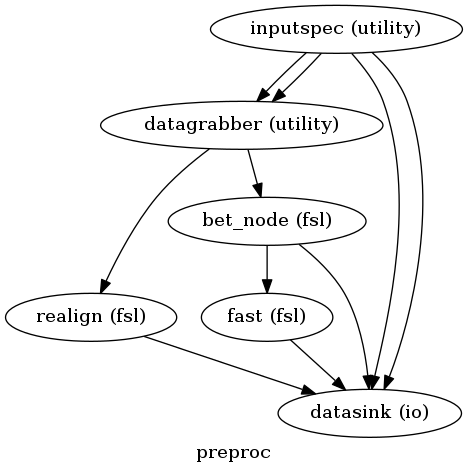

In [20]:
from IPython.display import Image
Image(graph)

In [21]:
wf.run()

170820-19:31:43,73 workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging']
170820-19:31:43,150 workflow INFO:
	 Running serially.
170820-19:31:43,156 workflow INFO:
	 Executing node datagrabber in dir: /data/working/preproc/datagrabber
170820-19:31:43,187 workflow INFO:
170820-19:31:43,229 workflow INFO:
	 Executing node realign in dir: /data/working/preproc/realign
170820-19:31:43,297 workflow INFO:
	 Executing node bet_node in dir: /data/working/preproc/bet_node
170820-19:31:43,327 workflow INFO:
170820-19:31:43,370 workflow INFO:
	 Executing node fast in dir: /data/working/preproc/fast
170820-19:31:43,405 workflow INFO:
170820-19:31:43,480 workflow INFO:
	 Executing node datasink in dir: /data/working/preproc/datasink
170820-19:31:43,780 interface INFO:
	 sub: /data/outputs/sub-01/func/_realign0/sub-01_task-flanker_run-1_bold_mcf.nii.gz -> /data/outputs/sub-01/func/sub-01_task-flanker_run-1_bold_mcf.nii.gz
170820-19:31:43,802 interface INFO:
	 sub: /data/output

## Rewire a workflow

You don't need to change someone else's code. You just need to look at the graph, remove/replace whatever you want.

#### Remove a node

In [22]:
base_wf = get_preproc_workflow() #get the original workflow

realign = base_wf.get_node("realign") #get the node by its "name" property 
# -- not the same as the variable name, mcflirt

base_wf.remove_nodes([realign])

170820-19:31:51,919 workflow INFO:
	 Generated workflow graph: ./working/preproc/graph.dot.png (graph2use=hierarchical, simple_form=True).


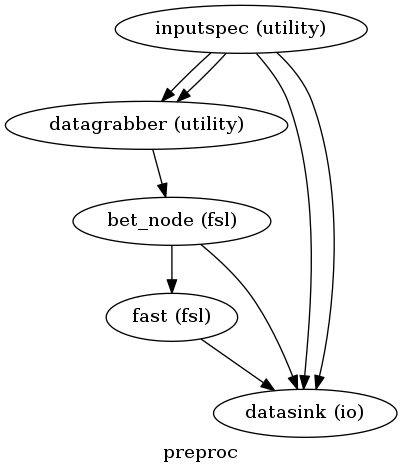

In [23]:
graph = base_wf.write_graph()
Image(graph)

#### Insert a new node and reconnect

In [24]:
from nipype.algorithms.misc import Gunzip
from nipype.interfaces.spm import Realign 

gunzip = MapNode(Gunzip(), name="gunzipper", iterfield=["in_file"]) 
datagrabber = base_wf.get_node("datagrabber")
datasink = base_wf.get_node("datasink")
realign = Node(Realign(), name="spm_realign")

base_wf.connect(datagrabber, "bolds", gunzip, "in_file")
base_wf.connect(gunzip, "out_file", realign, "in_files")
base_wf.connect(realign, "realigned_files", datasink, "func.@realigned" )
base_wf.connect(realign, "realignment_parameters", datasink, "func.@realigned_params" )
base_wf.connect(realign, "mean_image", datasink, "func.mean" )

170820-19:31:54,874 workflow INFO:
	 Generated workflow graph: ./working/preproc/graph.dot.png (graph2use=hierarchical, simple_form=True).


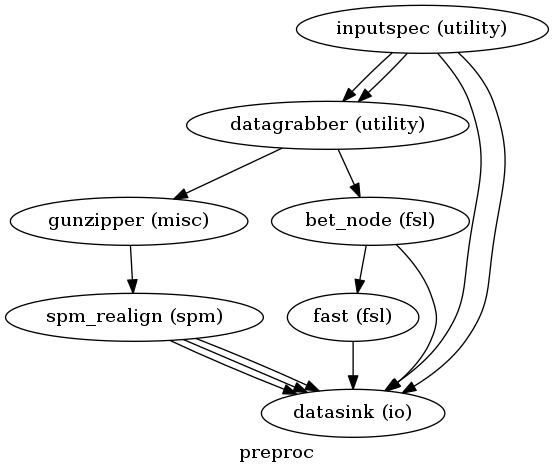

In [25]:
graph = base_wf.write_graph()
Image(graph)

In [26]:
base_wf.inputs.inputspec.output_directory = os.path.abspath("outputs")
base_wf.inputs.inputspec.subject = "sub-01"
base_wf.inputs.inputspec.data_directory = os.path.abspath("data/ds102_R2.0.0/")

base_wf.run()

170820-19:31:55,563 workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging']
170820-19:31:55,691 workflow INFO:
	 Running serially.
170820-19:31:55,701 workflow INFO:
	 Executing node datagrabber in dir: /data/working/preproc/datagrabber
170820-19:31:55,751 workflow INFO:
170820-19:31:55,794 workflow INFO:
	 Executing node gunzipper in dir: /data/working/preproc/gunzipper
170820-19:31:55,885 workflow INFO:
	 Executing node spm_realign in dir: /data/working/preproc/spm_realign
170820-19:31:55,936 workflow INFO:
170820-19:31:56,2 workflow INFO:
	 Executing node bet_node in dir: /data/working/preproc/bet_node
170820-19:31:56,33 workflow INFO:
170820-19:31:56,74 workflow INFO:
	 Executing node fast in dir: /data/working/preproc/fast
170820-19:31:56,106 workflow INFO:
170820-19:31:56,200 workflow INFO:
	 Executing node datasink in dir: /data/working/preproc/datasink


In [29]:
ls outputs/*/*

outputs/sub-01/anat:
fast/  sub-01_T1w_brain.nii.gz

outputs/sub-01/func:
mean/
rp_sub-01_task-flanker_run-1_bold.txt
rp_sub-01_task-flanker_run-2_bold.txt
rsub-01_task-flanker_run-1_bold.nii
rsub-01_task-flanker_run-2_bold.nii
sub-01_task-flanker_run-1_bold_mcf.nii.gz
sub-01_task-flanker_run-2_bold_mcf.nii.gz


### Problems

1. rewire the above workflow to add SPM's smooth on the two functional runs

## Iterables

Now we want to run this workflow on all subjects. We could run a for loop, but the nipype way is to use **iterables**

In [60]:
wf = get_preproc_workflow() #get the original workflow


wf.inputs.inputspec.output_directory = os.path.abspath("outputs")

#################################################################
#################################################################

inputspec = wf.get_node("inputspec")
inputspec.iterables = ("subject", ["sub-01", "sub-02"]) #iterate on subject

#################################################################
#################################################################

wf.inputs.inputspec.data_directory = os.path.abspath("data/ds102_R2.0.0/")

wf.run()

170820-22:47:31,212 workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging']
170820-22:47:31,311 workflow INFO:
	 Running serially.
170820-22:47:31,316 workflow INFO:
	 Executing node datagrabber.a1 in dir: /data/working/preproc/_subject_sub-02/datagrabber
170820-22:47:31,357 workflow INFO:
170820-22:47:31,401 workflow INFO:
	 Executing node bet_node.a1 in dir: /data/working/preproc/_subject_sub-02/bet_node
170820-22:47:31,456 workflow INFO:
170820-22:47:31,498 workflow INFO:
	 Executing node fast.a1 in dir: /data/working/preproc/_subject_sub-02/fast
170820-22:47:31,546 workflow INFO:
170820-22:47:31,594 workflow INFO:
	 Executing node realign.a1 in dir: /data/working/preproc/_subject_sub-02/realign
170820-22:47:31,725 workflow INFO:
	 Executing node datasink.a1 in dir: /data/working/preproc/_subject_sub-02/datasink
170820-22:47:31,917 interface INFO:
	 sub: /data/outputs/sub-02/func/_subject_sub-02/_realign0/sub-02_task-flanker_run-1_bold_mcf.nii.gz -> /data/outpu

In [96]:
ls outputs/*/*

outputs/sub-01/anat:
_subject_sub-01/  sub-01_T1w_brain.nii.gz
fast/             sub-01_T1w_brain_flirt_merged_mean.nii.gz

outputs/sub-01/func:
_subject_sub-01/
mean/
rp_sub-01_task-flanker_run-1_bold.txt
rp_sub-01_task-flanker_run-2_bold.txt
rsub-01_task-flanker_run-1_bold.nii
rsub-01_task-flanker_run-2_bold.nii
sub-01_task-flanker_run-1_bold_mcf.nii.gz
sub-01_task-flanker_run-2_bold_mcf.nii.gz

outputs/sub-02/anat:
_subject_sub-02/  fast/  sub-01_T1w_brain_flirt_merged_mean.nii.gz

outputs/sub-02/func:
_subject_sub-02/


### Problems

1. Fix the datasink so that the filenames are not ugly (`_subject_id_01` folder shouldn't be there)

## JoinNode

Once you start an iterable, you cannot bring the outputs back together, unless with a JoinNode

In [75]:
from nipype.interfaces.fsl import Merge

In [76]:
Merge().help()

Wraps command **fslmerge**

Use fslmerge to concatenate images

Images can be concatenated across time, x, y, or z dimensions. Across the
time (t) dimension the TR is set by default to 1 sec.

Note: to set the TR to a different value, specify 't' for dimension and
specify the TR value in seconds for the tr input. The dimension will be
automatically updated to 'tr'.

Examples
--------

>>> from nipype.interfaces.fsl import Merge
>>> merger = Merge()
>>> merger.inputs.in_files = ['functional2.nii', 'functional3.nii']
>>> merger.inputs.dimension = 't'
>>> merger.inputs.output_type = 'NIFTI_GZ'
>>> merger.cmdline # doctest: +ALLOW_UNICODE
'fslmerge -t functional2_merged.nii.gz functional2.nii functional3.nii'
>>> merger.inputs.tr = 2.25
>>> merger.cmdline # doctest: +ALLOW_UNICODE
'fslmerge -tr functional2_merged.nii.gz functional2.nii functional3.nii 2.25'

Inputs::

	[Mandatory]
	dimension: ('t' or 'x' or 'y' or 'z' or 'a')
		dimension along which to merge, optionally set tr input when
	

In [92]:
wf = get_preproc_workflow() #get the original workflow

wf.inputs.inputspec.output_directory = os.path.abspath("outputs")

inputspec = wf.get_node("inputspec")
inputspec.iterables = ("subject", ["sub-01", "sub-02"]) #iterate on subject

wf.inputs.inputspec.data_directory = os.path.abspath("data/ds102_R2.0.0/")

bet = wf.get_node("bet_node")
from nipype.interfaces.fsl import FLIRT
from nipype import JoinNode

flirt = Node(FLIRT(), name="flirt")
flirt.inputs.reference = os.path.abspath("data/OASIS-30_Atropos_template_in_MNI152.nii.gz")
wf.connect(bet, "out_file", flirt, "in_file")

from nipype.interfaces.fsl import Merge
from nipype.interfaces.fsl import MeanImage

inputspec = wf.get_node("inputspec")

#################################################################
#################################################################


join = JoinNode(Merge(dimension="t"), 
               name="bad_joiner", 
               joinfield=["in_files"], 
               joinsource=inputspec)

ave = Node(MeanImage(dimension="T"), name="bad_averager")
sink = wf.get_node("datasink")

wf.connect(flirt, "out_file", join, "in_files")
wf.connect(join, "merged_file", ave, "in_file")
wf.connect(ave, "out_file", sink, "anat.@bad_ave")

#################################################################
#################################################################


wf.run()

170820-23:06:29,367 workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging']
170820-23:06:29,551 workflow INFO:
	 Running serially.
170820-23:06:29,553 workflow INFO:
	 Executing node datagrabber.a1 in dir: /data/working/preproc/_subject_sub-02/datagrabber
170820-23:06:29,583 workflow INFO:
170820-23:06:29,619 workflow INFO:
	 Executing node bet_node.a1 in dir: /data/working/preproc/_subject_sub-02/bet_node
170820-23:06:29,657 workflow INFO:
170820-23:06:29,699 workflow INFO:
	 Executing node fast.a1 in dir: /data/working/preproc/_subject_sub-02/fast
170820-23:06:29,728 workflow INFO:
170820-23:06:29,793 workflow INFO:
	 Executing node flirt.a1 in dir: /data/working/preproc/_subject_sub-02/flirt
170820-23:06:29,822 workflow INFO:
170820-23:06:29,862 workflow INFO:
	 Executing node realign.a1 in dir: /data/working/preproc/_subject_sub-02/realign
170820-23:06:29,926 workflow INFO:
	 Executing node datagrabber.a0 in dir: /data/working/preproc/_subject_sub-01/datagrabb

In [102]:
ls -la outputs/*/anat

outputs/sub-01/anat:
total 9688
drwxr-xr-x 6 anisha users     204 Aug 20 23:06 ./
drwxr-xr-x 4 anisha users     136 Aug 20 17:28 ../
drwxr-xr-x 3 anisha users     102 Aug 20 19:54 _subject_sub-01/
drwxr-xr-x 4 anisha users     136 Aug 20 19:54 fast/
-rw-r--r-- 2 anisha users 2466535 Aug 20 15:19 sub-01_T1w_brain.nii.gz
-rw-r--r-- 3 anisha users 7447837 Aug 20 23:06 sub-01_T1w_brain_flirt_merged_mean.nii.gz

outputs/sub-02/anat:
total 7276
drwxr-xr-x 5 anisha users     170 Aug 20 23:06 ./
drwxr-xr-x 4 anisha users     136 Aug 20 19:47 ../
drwxr-xr-x 3 anisha users     102 Aug 20 19:47 _subject_sub-02/
drwxr-xr-x 3 anisha users     102 Aug 20 19:47 fast/
-rw-r--r-- 3 anisha users 7447837 Aug 20 23:06 sub-01_T1w_brain_flirt_merged_mean.nii.gz


#### Problems:
    
1. Add a smooth node on the skull-stripped anatomical image, and smooth at FWHM 4 and 8 with an iterable
2. Then, write a JoinNode to merge and then average the images

Probably a good idea to have a different datasink node for items after the join!

## Errors

Lets have a look at some [common errors](https://djarecka.github.io/nipype_tutorial/notebooks/basic_error_and_crashes.html) in Nipype

## Execution

[You can run nipype workflows in parallel pretty easily](https://djarecka.github.io/nipype_tutorial/notebooks/basic_plugins.html)

# Questions?